In [82]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

from keras.models import Sequential, Model
from keras import layers
from keras import Input

from sklearn.preprocessing import LabelEncoder

pd.set_option('display.max_columns', None)

In [5]:
mlb20 = pd.read_csv('data/2020cleaned.csv')

mlb20.columns

Index(['game_date', 'pitch_type', 'Pitcher_name', 'pitcher_id', 'batter_name',
       'batter_id', 'release_speed', 'release_pos_x', 'release_pos_z', 'stand',
       'p_throws', 'balls', 'strikes', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z',
       'on_3b', 'on_2b', 'on_1b', 'inning', 'inning_topbot', 'effective_speed',
       'release_spin_rate', 'release_extension', 'Catcher', 'FirstBasemen',
       'SecondBasemen', 'ThirdBasemen', 'ShortStop', 'LeftField',
       'CenterField', 'RightField', 'at_bat_number', 'pitch_number',
       'pitch_name', 'bat_score', 'fld_score', 'post_bat_score',
       'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment',
       'count', 'strike_attempt', 'events', 'description', 'type', 'bb_type',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'outs_when_up'],
      dtype='object')

In [83]:
mlb20.head()

,game_date,pitch_type,Pitcher_name,pitcher_id,batter_name,batter_id,release_speed,release_pos_x,release_pos_z,stand,p_throws,balls,strikes,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,inning,inning_topbot,effective_speed,release_spin_rate,release_extension,Catcher,FirstBasemen,SecondBasemen,ThirdBasemen,ShortStop,LeftField,CenterField,RightField,at_bat_number,pitch_number,pitch_name,bat_score,fld_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,count,strike_attempt,events,description,type,bb_type,vx0,vy0,vz0,ax,ay,az,outs_when_up
0,2020-10-27,FF,Julio Urias,628711,Willy Adames,642715,96.7,1.58,5.99,1,0,0,2,0.2,1.6,-0.53,2.29,0,0,0,9,1,95.4,2615.0,5.7,605131,571970,571771,621458,608369,621035,641355,605141,65,3,4-Seam Fastball,1,3,1,3,Standard,Standard,0-2,strike,strikeout,called_strike,S,NaN,-5.950264,-140.490456,-7.897391,3.772000,32.321911,-8.981441,2
1,2020-10-27,FF,Julio Urias,628711,Willy Adames,642715,94.1,2.91,5.45,1,0,0,1,0.8,1.3,-0.55,3.03,0,0,0,9,1,93.4,2470.0,5.9,605131,571970,571771,621458,608369,621035,641355,605141,65,2,4-Seam Fastball,1,3,1,3,Standard,Standard,0-1,strike,NaN,called_strike,S,NaN,-10.560246,-136.599519,-3.429867,11.723598,29.183810,-15.237217,2
2,2020-10-27,FF,Julio Urias,628711,Willy Adames,642715,94.9,1.77,6.02,1,0,0,0,0.2,1.5,-0.04,3.32,0,0,0,9,1,94.0,2397.0,5.7,605131,571970,571771,621458,608369,621035,641355,605141,65,1,4-Seam Fastball,1,3,1,3,Standard,Standard,0-0,strike,NaN,swinging_strike,S,NaN,-5.199252,-138.098234,-4.637970,4.158758,30.838499,-12.535677,2
3,2020-10-27,FF,Julio Urias,628711,Mike Brosseau,670712,94.4,1.66,5.93,1,0,3,2,0.3,1.5,-0.37,2.15,0,0,0,9,1,93.7,2508.0,5.9,605131,571970,571771,621458,608369,621035,641355,605141,64,6,4-Seam Fastball,1,3,1,3,Standard,Standard,3-2,strike,strikeout,called_strike,S,NaN,-5.843595,-137.294295,-7.414897,4.754147,30.016237,-11.778755,1
4,2020-10-27,CU,Julio Urias,628711,Mike Brosseau,670712,81.4,1.46,6.06,1,0,2,2,-1.7,-0.2,-0.14,0.96,0,0,0,9,1,80.2,3031.0,5.7,605131,571970,571771,621458,608369,621035,641355,605141,64,5,Curveball,1,3,1,3,Standard,Standard,2-2,ball,NaN,ball,B,NaN,-0.383207,-118.447810,-4.454166,-15.553576,24.451936,-32.892744,1


In [7]:
mlb20 = mlb20[mlb20['release_speed'].notnull()]
mlb20.isnull().sum()

game_date                     0
pitch_type                    0
Pitcher_name                  0
pitcher_id                    0
batter_name                   0
batter_id                     0
release_speed                 0
release_pos_x                 0
release_pos_z                 0
stand                         0
p_throws                      0
balls                         0
strikes                       0
pfx_x                         0
pfx_z                         0
plate_x                       0
plate_z                       0
on_3b                         0
on_2b                         0
on_1b                         0
inning                        0
inning_topbot                 0
effective_speed               0
release_spin_rate           346
release_extension           587
Catcher                       0
FirstBasemen                  0
SecondBasemen                 0
ThirdBasemen                  0
ShortStop                     0
LeftField                     0
CenterFi

In [97]:
# Selecting branches for multi input
pitch_selection_branch = mlb20['pitch_name']
pitcher_coordinate_branch = mlb20[['release_speed', 'release_pos_x', 'release_pos_z', 'p_throws']]
plate_coordinate_branch = mlb20[['pfx_x', 'pfx_z', 'plate_x', 'plate_z']]
score_branch = mlb20[['bat_score', 'fld_score']]
align_branch = mlb20[['if_fielding_alignment', 'of_fielding_alignment']]
target = mlb20['strike_attempt']

In [98]:
le = LabelEncoder().fit(target)
target20 = le.transform(target)

In [99]:
target20

array([3, 3, 3, ..., 3, 0, 0])

In [16]:
pitcher_coordinate_branch.head()

,release_speed,release_pos_x,release_pos_z,p_throws
0,96.7,1.58,5.99,0
1,94.1,2.91,5.45,0
2,94.9,1.77,6.02,0
3,94.4,1.66,5.93,0
4,81.4,1.46,6.06,0


In [17]:
plate_coordinate_branch.head()

,pfx_x,pfx_z,plate_x,plate_z
0,0.2,1.6,-0.53,2.29
1,0.8,1.3,-0.55,3.03
2,0.2,1.5,-0.04,3.32
3,0.3,1.5,-0.37,2.15
4,-1.7,-0.2,-0.14,0.96


In [18]:
score_branch.head()

,bat_score,fld_score
0,1,3
1,1,3
2,1,3
3,1,3
4,1,3


In [63]:
pitcher_coordinate_branch.shape

(279652, 4)

In [64]:
plate_coordinate_branch.shape

(279652, 4)

## Training on 2020 Season

In [106]:
# model = Sequential()

release_input = Input(shape=(None,4),name='pitcher_coordinates') # pitchers coordinates
plate_input = Input(shape=(None,4),name='plate_coordinates')

concatenated = layers.concatenate([release_input, plate_input])

aim = layers.Dense(4, activation='softmax')(concatenated) # Answer between 'strike','out','ball','ob'

model = Model([release_input, plate_input], aim)
model.compile(optimizer='adam',
              loss=['mse','categorical_crossentropy'],
              metrics=['acc'])

In [101]:
hist = model.fit({'pitcher_coordinates':pitcher_coordinate_branch, 'plate_coordinates':plate_coordinate_branch},
                 target20, # does this need to be one hot encoded
                 epochs=100, batch_size=128)

Epoch 1/100
2185/2185 [==============================] - 1s 531us/step - loss: 3.9570 - acc: 0.4243
Epoch 2/100
2185/2185 [==============================] - 1s 548us/step - loss: 3.9148 - acc: 0.2506
Epoch 3/100
2185/2185 [==============================] - 1s 531us/step - loss: 3.9105 - acc: 0.2420
Epoch 4/100
2185/2185 [==============================] - 1s 579us/step - loss: 3.9105 - acc: 0.2786
Epoch 5/100
2185/2185 [==============================] - 1s 595us/step - loss: 3.9105 - acc: 0.3013
Epoch 6/100
2185/2185 [==============================] - 1s 535us/step - loss: 3.9105 - acc: 0.3259
Epoch 7/100
2185/2185 [==============================] - 1s 542us/step - loss: 3.9105 - acc: 0.2752
Epoch 8/100
2185/2185 [==============================] - 1s 530us/step - loss: 3.9105 - acc: 0.3220
Epoch 9/100
2185/2185 [==============================] - 1s 555us/step - loss: 3.9105 - acc: 0.2853
Epoch 10/100
2185/2185 [==============================] - 1s 524us/step - loss: 3.9105 - acc: 0.2777

2185/2185 [==============================] - 1s 552us/step - loss: 3.9105 - acc: 0.2972
Epoch 74/100
2185/2185 [==============================] - 1s 578us/step - loss: 3.9105 - acc: 0.3113
Epoch 75/100
2185/2185 [==============================] - 1s 517us/step - loss: 3.9105 - acc: 0.3099
Epoch 76/100
2185/2185 [==============================] - 1s 511us/step - loss: 3.9105 - acc: 0.2693
Epoch 77/100
2185/2185 [==============================] - 1s 501us/step - loss: 3.9105 - acc: 0.3200
Epoch 78/100
2185/2185 [==============================] - 1s 530us/step - loss: 3.9105 - acc: 0.3256
Epoch 79/100
2185/2185 [==============================] - 1s 554us/step - loss: 3.9105 - acc: 0.2893
Epoch 80/100
2185/2185 [==============================] - 1s 518us/step - loss: 3.9105 - acc: 0.3048
Epoch 81/100
2185/2185 [==============================] - 1s 544us/step - loss: 3.9105 - acc: 0.3163
Epoch 82/100
2185/2185 [==============================] - 1s 555us/step - loss: 3.9105 - acc: 0.3095
Epo

In [102]:
hist.history

{'loss': [3.9569528102874756,
  3.914811611175537,
  3.9105446338653564,
  3.9105446338653564,
  3.9105446338653564,
  3.9105446338653564,
  3.9105441570281982,
  3.9105446338653564,
  3.910545587539673,
  3.9105446338653564,
  3.9105446338653564,
  3.9105451107025146,
  3.9105441570281982,
  3.9105446338653564,
  3.9105451107025146,
  3.9105446338653564,
  3.9105446338653564,
  3.9105451107025146,
  3.9105446338653564,
  3.9105446338653564,
  3.9105441570281982,
  3.9105446338653564,
  3.9105451107025146,
  3.9105446338653564,
  3.9105446338653564,
  3.9105446338653564,
  3.9105441570281982,
  3.9105446338653564,
  3.9105446338653564,
  3.9105451107025146,
  3.9105441570281982,
  3.9105446338653564,
  3.9105451107025146,
  3.9105441570281982,
  3.9105446338653564,
  3.9105446338653564,
  3.9105446338653564,
  3.9105446338653564,
  3.9105446338653564,
  3.9105446338653564,
  3.9105446338653564,
  3.9105446338653564,
  3.9105446338653564,
  3.9105441570281982,
  3.9105446338653564,
  3.

In [104]:
model.predict({'pitcher_coordinates':pitcher_coordinate_branch19, 'plate_coordinates':plate_coordinate_branch19})

array([[0.33325368, 0.33334267, 0.        , 0.3334037 ],
       [0.33312187, 0.33333796, 0.        , 0.3335402 ],
       [0.33336386, 0.33334732, 0.        , 0.33328882],
       ...,
       [0.33327782, 0.3333414 , 0.        , 0.33338082],
       [0.3333753 , 0.33334607, 0.        , 0.3332787 ],
       [0.3331939 , 0.33334008, 0.        , 0.333466  ]], dtype=float32)

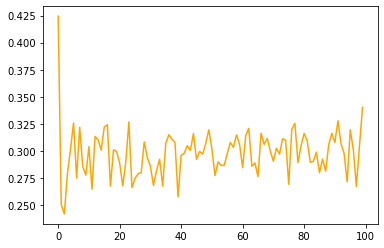

In [103]:
# Check how 2020 data did against 2019 data
plt.plot(hist.epoch, hist.history['acc'], c='orange')
# plt.plot(hist.epoch, hist.history['loss'], c='b')

In [40]:
mlb19 = pd.read_csv('data/2019cleaned.csv')
mlb19.isnull().sum()

game_date                     0
pitch_type                    0
Pitcher_name                  0
pitcher_id                    0
batter_name                   0
batter_id                     0
release_speed                 2
release_pos_x                 0
release_pos_z                 0
stand                         0
p_throws                      0
balls                         0
strikes                       0
pfx_x                         0
pfx_z                         0
plate_x                       0
plate_z                       0
on_3b                         0
on_2b                         0
on_1b                         0
inning                        0
inning_topbot                 0
effective_speed               2
release_spin_rate         12807
release_extension             2
Catcher                       0
FirstBasemen                  0
SecondBasemen                 0
ThirdBasemen                  0
ShortStop                     0
LeftField                     0
CenterFi

In [39]:
mlb19 = mlb19[mlb19['release_pos_x'].notnull()]

In [41]:
# Test begins here
pitcher_coordinate_branch19 = mlb19[['release_speed', 'release_pos_x', 'release_pos_z', 'p_throws']]
plate_coordinate_branch19 = mlb19[['pfx_x', 'pfx_z', 'plate_x', 'plate_z']]

In [71]:
pitcher_coordinate_branch19.head()

,release_speed,release_pos_x,release_pos_z,p_throws
0,87.9,-2.65,5.50,1
1,95.9,-2.77,5.52,1
2,96.5,-2.68,5.42,1
3,96.0,-2.65,5.55,1
4,86.7,-2.73,5.59,1


In [72]:
plate_coordinate_branch19.head()

,pfx_x,pfx_z,plate_x,plate_z
0,0.0,0.2,0.88,1.03
1,-0.6,1.5,-0.47,1.92
2,-0.7,1.4,1.68,1.35
3,-0.8,1.5,0.75,2.05
4,-0.1,0.5,1.27,2.17


In [53]:
target19 = mlb19['strike_attempt']
target19

0         strike
1         strike
2           ball
3         strike
4           ball
           ...  
742878    strike
742879    strike
742880    strike
742881    strike
742882       out
Name: strike_attempt, Length: 737815, dtype: object

In [61]:
target19_encoded = le.transform(target19)

In [ ]:
# RNN Model where 2019 is the training set

In [84]:
release_input = Input(shape=(None,4),name='pitcher_coordinates')
plate_input = Input(shape=(None,4),name='plate_coordinates')

concatenated = layers.concatenate([release_input, plate_input])

aim = layers.Dense(1, activation='softmax')(concatenated) # Answer between 'strike','out','ball','ob'

model = Model([release_input, plate_input], aim)
model.compile(optimizer='adam',
              loss=['mse','categorical_crossentropy'],
              metrics=['acc'])

In [ ]:
# only takes in numerical numbers for NN


In [ ]:
# Rachel tasks

# Follow up with Rachel after Riley meeting
# Reach out to one of the folks on Activision and ask for Informational Interview and talk about commonality of GA
# Reach out to people in the cohort and ask about how they feeling or something or proactive and stuff, SIMP together